In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import os
from datetime import datetime,timezone

In [2]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [3]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0,0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0,0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0,0
...,...,...,...,...,...,...,...
2022-11-17 00:00:00-05:00,3919.260010,3954.330078,3906.540039,3946.560059,4051780000,0,0
2022-11-18 00:00:00-05:00,3966.389893,3979.889893,3935.979980,3965.340088,4037360000,0,0
2022-11-21 00:00:00-05:00,3956.229980,3962.000000,3933.340088,3949.939941,3850690000,0,0


In [4]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23840 entries, 1927-12-30 00:00:00-05:00 to 2022-11-23 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          23840 non-null  float64
 1   High          23840 non-null  float64
 2   Low           23840 non-null  float64
 3   Close         23840 non-null  float64
 4   Volume        23840 non-null  int64  
 5   Dividends     23840 non-null  int64  
 6   Stock Splits  23840 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 1.5+ MB


In [6]:
sp500.index = pd.to_datetime(sp500.index)

sp500 = sp500.drop(['Dividends','Stock Splits'],axis=1)

sp500 = sp500[sp500.index> datetime(1990,12,31,tzinfo=timezone.utc)]

Now, lets create a target variable that says whether tomorrows price is larger (True) or smaller (False)

In [8]:
sp500['Target'] = None
for i in range(0,len(sp500)-1):
    if sp500['Close'].iloc[i] < sp500['Close'].iloc[i+1]:
        sp500['Target'].iloc[i] = 1
    else:
        sp500['Target'].iloc[i] = 0
sp500 = sp500.dropna()

C:\Users\marku\AppData\Local\Temp\ipykernel_12468\3773221041.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['Target'].iloc[i] = 0
C:\Users\marku\AppData\Local\Temp\ipykernel_12468\3773221041.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['Target'].iloc[i] = 1


In [23]:
sp500['Target'] = sp500['Target'].astype(int)
sp500['Target'].value_counts(normalize=True)

1    0.53515
0    0.46485
Name: Target, dtype: float64

So, now its time to build a model. Because we want to keep the order of the the data (we can not make predictions on past data with future data) cross validation wont work. However, it is possible to first define the train/test data and then use ParameterGrid for hyperparameter optimization.


First, we are going to define librarys from sklearn

In [62]:
from sklearn.model_selection import train_test_split,ParameterGrid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [67]:
KNeighbors = {'name':'KNeighborsClassifier',
             'estimator':KNeighborsClassifier(),
             'hyperparameters': {
                 'n_neighbors':range(1,20,2),
                 'weights':['distance','uniform'],
                 'algorithm':['ball_tree','kd_tree','brute'],
                 'p':[1,2]}
             }
Logistic = {'name':'LogisticRegression',
            'estimator':LogisticRegression(max_iter=10000),
            'hyperparameters':{
                'solver': ["newton-cg", "lbfgs", "liblinear"]}
           }
RandomForest = {'name':'RandomForest',
                'estimator':RandomForestClassifier(),
                'hyperparameters':{
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]}
               }

model_list = [KNeighbors,Logistic,RandomForest]

features = sp500.drop('Target',axis=1).columns


Lets define train and test data, where the train data is oldest, and test data is the newest.

In [68]:
NUM_ROWS = sp500.shape[0]
TEST_SIZE = 0.3
indices = np.arange(NUM_ROWS)

# usual train-val split
train_idx, test_idx = train_test_split(indices, test_size=TEST_SIZE,shuffle=False)
train = sp500.iloc[train_idx]
test = sp500.iloc[test_idx]


Lets define a function that takes in a model list with its corresponding hyper parameters, fits and calculates the accuracy score, and then returns the best score and parameters for each of the models in the model list.

In [69]:
def model_selection(model_list,df,features,target):

    # Split data in train/test (note that the order of the data is kept)
    NUM_ROWS = df.shape[0]
    TEST_SIZE = 0.3
    indices = np.arange(NUM_ROWS)
    train_idx, test_idx = train_test_split(indices, test_size=TEST_SIZE,shuffle=False)
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]
    
    # Hyperparameter optimization. Here, the model list will be iterated through
    # and each of the parameters in "hyperparameters" will be tested with the help of ParameterGrid()
    best_params_dict = {}
    for model in model_list:
        parameters = model['hyperparameters']
        best_score = 0
        for params in ParameterGrid(parameters):
            estimator = model['estimator'].set_params(**params)
            estimator.fit(train[features],train['Target'])
            predictions = estimator.predict(test[features])
            accuracy = accuracy_score(predictions,test['Target'])
            if accuracy > best_score:
                best_score = accuracy
                best_params_dict[model['name']] = {'Best Score': best_score,'Best parameters': params}
    return best_params_dict

In [70]:
best_params_dict = model_selection(model_list,sp500,features,'Target')

C:\Users\marku\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\marku\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\marku\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\scipy\optimize\_linesearch.py:415: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\marku\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


In [71]:
best_params_dict

{'KNeighborsClassifier': {'Best Score': 0.5315091210613598,
  'Best parameters': {'algorithm': 'ball_tree',
   'n_neighbors': 17,
   'p': 1,
   'weights': 'uniform'}},
 'LogisticRegression': {'Best Score': 0.5406301824212272,
  'Best parameters': {'solver': 'newton-cg'}},
 'RandomForest': {'Best Score': 0.5435323383084577,
  'Best parameters': {'criterion': 'entropy',
   'max_depth': 2,
   'max_features': 'log2',
   'min_samples_leaf': 5,
   'min_samples_split': 2,
   'n_estimators': 4}}}

So it seems that RandomForest produces the best results (marginally). Lets pick RandomForest and lets do some backtesting. Backtesting is a more robust way of predicting the stock market, where you e.g. use the first 10 years to predict the 11 th years prices, and then use the first 11 years to predict the 12th years prices (and so on). Lets make a function to automate it. But first, lets make a function creates a RandomForest model that predicts the accuracy, with the train and test data from the backtesting function as input

In [146]:
def model_execution(train,test,features,target,params):
    rf = RandomForestClassifier()
    rf.set_params(**params)
    rf.fit(train[features],train[target])
    predictions = rf.predict(test[features])
    accuracy = accuracy_score(test[target],predictions)
    return accuracy

In [147]:
def backtesting(df,start_year,end_year,features,target,params):
    accuracy_list = list()
    for i in range(start_year-1,end_year):
        train_data = df[df.index>=datetime(i,12,31,tzinfo=timezone.utc)]
        test_data = df[(datetime(i,12,31,tzinfo=timezone.utc)<df.index)
                       &(datetime(i+1,12,31,tzinfo=timezone.utc)>=df.index)]
        accuracy_list.append(model_execution(train_data,test_data,features,target,params))
    
    return accuracy_list

In [148]:
params = best_params_dict['RandomForest']['Best parameters']
accuracy_over_time = backtesting(sp500,2000,2022,features,'Target',params)

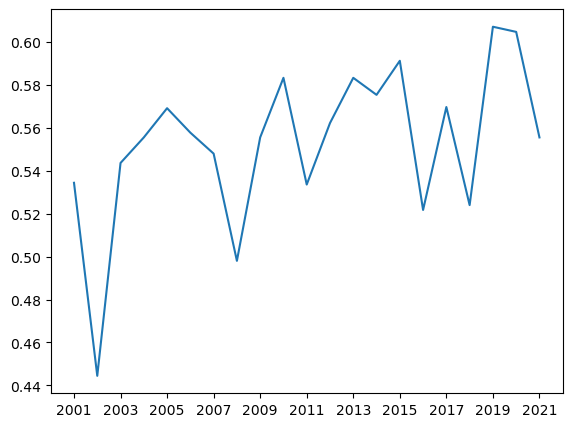

In [110]:
fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])
x = range(2001,2022)
y = accuracy_over_time
ax.plot(x,y)
ax.set_xticks(range(2001,2022,2))

In [112]:
max(accuracy_over_time)

0.6071428571428571

In [113]:
min(accuracy_over_time)

0.4444444444444444

As we can see, the accuracy goes up over time (which is not unexpected, since we get more years to calibrate from with every passing year). We manage to hit a maximum accuracy of 0.61 in the year 2019, and a low of 0.44 in the year 2002.

Since an accuracy of about 0.6 is not high enough to be a reliable accuracy, its time for some feature engineering. In the world in stock markets, many different predictors are used to forsee trends in stocks.

Here, I have decided to add the additional predictors: 

* Rolling averages over 5 days (for closing price and volume)
* Rolling averages over 30 days (for closing price and volume)
* The standard deviation of the average volume (for year and month)


In [117]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")


In [118]:
sp500.index = pd.to_datetime(sp500.index)
sp500 = sp500.drop(['Dividends','Stock Splits'],axis=1)


In [122]:
# Rolling averages for 5 days for closing price and volume
sp500['Closing_avg_5_days'] = sp500['Close'].rolling(5).mean()
sp500['Volume_avg_5_days'] = sp500['Volume'].rolling(5).mean()

#Rolling averages for 30 days for closing price and volume
sp500['Closing_avg_30_days'] = sp500['Close'].rolling(30).mean()
sp500['Volume_avg_30_days'] = sp500['Volume'].rolling(30).mean()

#Standard deviation of the average volume for year and month
sp500['Volume_std_30_days'] = sp500['Volume'].rolling(30).std()
sp500['Volume_std_year'] = sp500['Volume'].rolling(365).std()


In [124]:
sp500.tail()

,Open,High,Low,Close,Volume,Rolling_avg_5_days,Closing_avg_5_days,Volume_avg_5_days,Closing_avg_30_days,Volume_avg_30_days,Volume_std_30_days,Volume_std_year
Date,,,,,,,,,,,,
2022-11-17 00:00:00-05:00,3919.260010,3954.330078,3906.540039,3946.560059,4051780000,3969.452002,3969.452002,4.677530e+09,3784.775016,4.649803e+09,4.447091e+08,8.674517e+08
2022-11-18 00:00:00-05:00,3966.389893,3979.889893,3935.979980,3965.340088,4037360000,3963.934033,3963.934033,4.366340e+09,3795.631022,4.636059e+09,4.573002e+08,8.677137e+08
2022-11-21 00:00:00-05:00,3956.229980,3962.000000,3933.340088,3949.939941,3850690000,3962.472021,3962.472021,4.224092e+09,3806.882690,4.636605e+09,4.563193e+08,8.676445e+08
2022-11-22 00:00:00-05:00,3965.510010,4005.879883,3956.879883,4003.580078,3887990000,3964.842041,3964.842041,3.998628e+09,3820.707357,4.607570e+09,4.755663e+08,8.679990e+08
2022-11-23 00:00:00-05:00,4000.300049,4033.780029,3998.659912,4027.260010,3279720000,3978.536035,3978.536035,3.821508e+09,3835.715023,4.583333e+09,5.233648e+08,8.698942e+08


Now, lets only pick the stocks after 1990, and transform the target column as previously (1 equals higher than yesterday, 0 equals lower than yesterday)

In [128]:
sp500 = sp500[sp500.index> datetime(1990,12,31,tzinfo=timezone.utc)]
sp500['Target'] = None
for i in range(0,len(sp500)-1):
    if sp500['Close'].iloc[i] < sp500['Close'].iloc[i+1]:
        sp500['Target'].iloc[i] = 1
    else:
        sp500['Target'].iloc[i] = 0
sp500 = sp500.dropna()
sp500['Target'] = sp500['Target'].astype(int)

C:\Users\marku\AppData\Local\Temp\ipykernel_12468\2478543698.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['Target'].iloc[i] = 0
C:\Users\marku\AppData\Local\Temp\ipykernel_12468\2478543698.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['Target'].iloc[i] = 1


In [129]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8036 entries, 1990-12-31 00:00:00-05:00 to 2022-11-21 00:00:00-05:00
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Open                 8036 non-null   float64
 1   High                 8036 non-null   float64
 2   Low                  8036 non-null   float64
 3   Close                8036 non-null   float64
 4   Volume               8036 non-null   int64  
 5   Rolling_avg_5_days   8036 non-null   float64
 6   Closing_avg_5_days   8036 non-null   float64
 7   Volume_avg_5_days    8036 non-null   float64
 8   Closing_avg_30_days  8036 non-null   float64
 9   Volume_avg_30_days   8036 non-null   float64
 10  Volume_std_30_days   8036 non-null   float64
 11  Volume_std_year      8036 non-null   float64
 12  Target               8036 non-null   int32  
dtypes: float64(11), int32(1), int64(1)
memory usage: 847.5+ KB


Now its time to once again pick a model and define its hyperparameters. The function that was written earlier will be used in the same way as before.

In [131]:
features = sp500.drop('Target',axis=1).columns
best_params_dict = model_selection(model_list,sp500,features,'Target')


C:\Users\marku\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\marku\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\marku\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\scipy\optimize\_linesearch.py:415: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\marku\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


In [132]:
best_params_dict

{'KNeighborsClassifier': {'Best Score': 0.5221899626710909,
  'Best parameters': {'algorithm': 'ball_tree',
   'n_neighbors': 15,
   'p': 1,
   'weights': 'uniform'}},
 'LogisticRegression': {'Best Score': 0.5404396515968478,
  'Best parameters': {'solver': 'newton-cg'}},
 'RandomForest': {'Best Score': 0.5445873081708834,
  'Best parameters': {'criterion': 'gini',
   'max_depth': 10,
   'max_features': 'sqrt',
   'min_samples_leaf': 5,
   'min_samples_split': 3,
   'n_estimators': 4}}}

So once more, the random forest takes the race! Lets use the hyperparameters from the hyperparameter optimization and lets predict the stock market using backtesting once more

In [139]:
params = best_params_dict['RandomForest']['Best parameters']
accuracy_over_time = backtesting(sp500,2000,2022,features,'Target',params)

Text(0, 0.5, 'Accuracy')

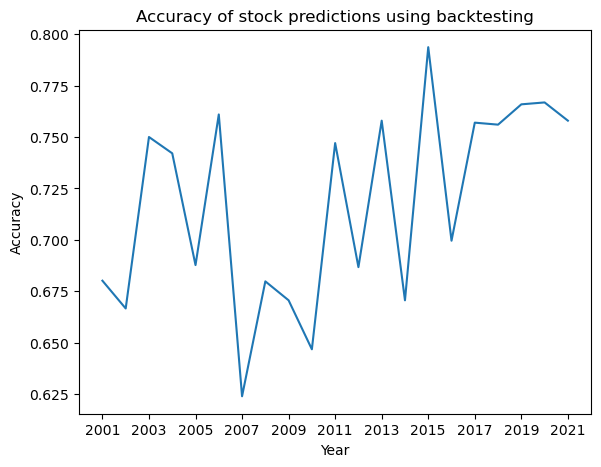

In [140]:
fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])
x = range(2001,2022)
y = accuracy_over_time
ax.plot(x,y)
ax.set_xticks(range(2001,2022,2))
ax.set_title('Accuracy of stock predictions using backtesting')
ax.set_xlabel('Year')
ax.set_ylabel('Accuracy')

In [141]:
max(accuracy_over_time)


0.7936507936507936

In [142]:
min(accuracy_over_time)

0.624

A significant increase! The feature engineering made previously paid off and more can be done.


For now, however, lets focus on the model and how it predicts whether the price has gone up or down through predict_proba. Lets set the threshold to 0.6 for now, meaning that the model has to be 60% sure that it is classifying correctly (vs. .predict() which has a defualt value of 0.5, or 50%) 

In [187]:
def model_execution_varying_threshold(train,test,features,target,params,threshold):
    rf = RandomForestClassifier()
    rf.set_params(**params)
    rf.fit(train[features],train[target])
    predictions = (rf.predict_proba(test[features])[:,1] >= threshold).astype(int)
    accuracy = accuracy_score(test[target],predictions)
    return accuracy

In [188]:
def backtesting_varying_threshold(df,start_year,end_year,features,target,params,threshold):
    accuracy_list = list()
    for i in range(start_year,end_year-1):
        train_data = df[df.index>=datetime(i,12,31,tzinfo=timezone.utc)]
        test_data = df[(datetime(i,12,31,tzinfo=timezone.utc)<df.index)
                       &(datetime(i+1,12,31,tzinfo=timezone.utc)>=df.index)]
        accuracy_list.append(model_execution_varying_threshold(train_data,test_data,features,target,
                                                                 params,threshold))
    
    return accuracy_list

In [189]:
accuracy_over_time = backtesting_increased_threshold(sp500,2000,2022,features,'Target',params,0.6)

Text(0, 0.5, 'Accuracy')

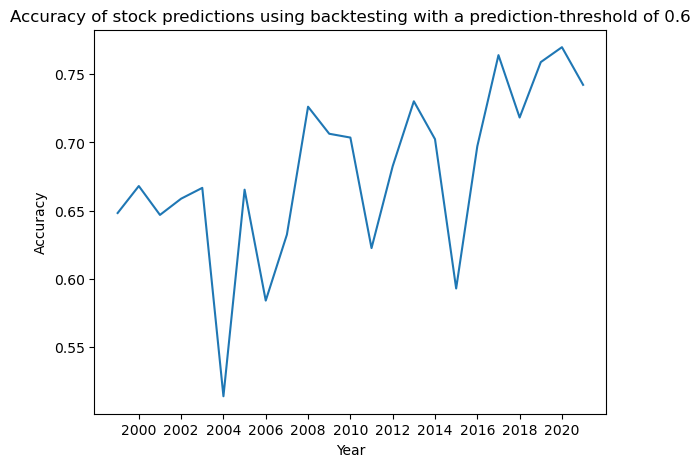

In [195]:
fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])
x = range(1999,2022)
y = accuracy_over_time
ax.plot(x,y)
ax.set_xticks(range(2000,2022,2))
ax.set_title('Accuracy of stock predictions using backtesting with a prediction-threshold of 0.6')
ax.set_xlabel('Year')
ax.set_ylabel('Accuracy')

In [193]:
max(accuracy_over_time)

0.7698412698412699

In [194]:
min(accuracy_over_time)

0.5138339920948617

To wrap up, this project was trying to predict the stock market using three different machine learning models. All the models were optimized with a set of hyper parameters and measured against eachother. In this project, the RandomForestClassifier performed the best results of the three, and it was picked with its optimized hyperparameters. Afterwards, the accuracy result was increased with the help of both feature engineering and by an increased threshold for the models predictions. Future work should include further feature engineering such as: inflation rates and other macroeconomic indicators, or comparing with key stocks or sectors within the S&P500. 